In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from src.config import *
from src.models.model_util import *
from src.data.data_util import *
from src.visualization.auggrad import *
from src.visualization.visual_utils import *

In [2]:
cfg = load_config()
cfg.model_name = 'resnet_no_maxpool'
model, cfg.device = load_model(cfg.model_name, verbose=False, cfg=cfg)
model.load_state_dict(torch.load('./result/models/2021_03_19_1412/best_resnet_no_maxpool_ep83-100_sd42_mae6.193.pth'))
# Dataloader
train_dataset = DatasetPlus(cfg, augment=False, test=True)
sample_dl = DataLoader(train_dataset, batch_size=16)

data = next(iter(sample_dl))

# Make SmoothGrad Instance
agrad = AugGrad(model, cfg)

# Forward a single brain with age to the SmoothGrad instance
print(data[1])

G:\My Drive\brain_data\workspace\3d_brain\src\config.py:17: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return CFG(yaml.load(yml_config_file))


Model Resnet_no_maxpool is selected.
tensor([64., 81., 32., 61., 38., 70., 52., 68., 72., 54., 81., 21., 77., 32.,
        35., 43.])


[valid] 10.3 sec 


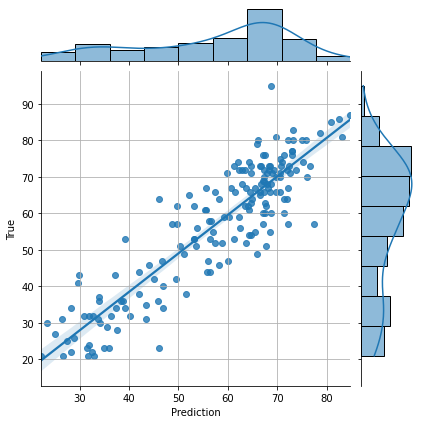

In [3]:
from src.training.losses import RMSELoss, fn_lst
from src.training.run import valid, make_df

tst_dp = DataPacket()
model, tst_dp, tst_res = valid(model, fn_lst, tst_dp, cfg, fold=None)

df = make_df(tst_res, 'test')
df.head()

sns.jointplot(data=df[df['Label'] == 'test'], x='Prediction', y='True', kind='reg')
plt.grid()

In [4]:
df[df['Prediction'] < 30]

,True,Prediction,Label
11,21.0,22.135773,test
15,43.0,29.751909,test
53,31.0,26.427156,test
63,26.0,28.881048,test
69,21.0,26.527990,test
71,22.0,28.297073,test
74,34.0,28.293619,test
103,25.0,27.332247,test
110,41.0,29.550917,test
131,30.0,23.445047,test


In [5]:
df[df['True'] < df['True'].mean() - 15]

,True,Prediction,Label
2,32.0,30.870901,test
4,38.0,42.003925,test
11,21.0,22.135773,test
13,32.0,40.195011,test
14,35.0,43.411926,test
20,23.0,45.959457,test
24,23.0,34.940998,test
27,29.0,35.618771,test
29,32.0,32.592045,test
32,22.0,32.504211,test


In [6]:
idx = -5
print(f'TRUE AGE: {float(data[1][idx].cpu())}')
smooth_grad = agrad(data[0][idx][None, ...].to(cfg.device), data[1][idx], verbose=True)

TRUE AGE: 21.0
[true]: 21
[pred]: 22.136
0th [flip]: 22.136
1th [elastic_deform]: 22.235
2th [elastic_deform]: 22.546
3th [flip]: 22.136
4th [affine]: 22.567
5th [affine]: 31.076
6th [affine]: 25.368
7th [elastic_deform]: 22.279
8th [flip]: 22.136
9th [elastic_deform]: 22.291
10th [affine]: 22.974
11th [elastic_deform]: 22.631
12th [elastic_deform]: 22.724
13th [affine]: 22.729
14th [affine]: 23.888
15th [affine]: 25.689
16th [affine]: 24.762
17th [flip]: 22.136
18th [flip]: 22.012
19th [affine]: 21.652
20th [flip]: 22.136
21th [affine]: 26.875
22th [affine]: 28.382
23th [flip]: 22.012
24th [flip]: 22.136


<AxesSubplot:>

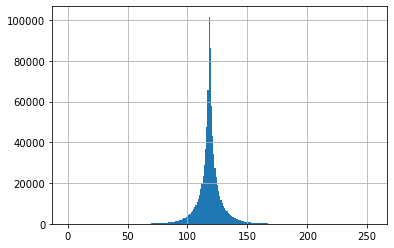

In [14]:
sg = pd.Series(smooth_grad[0].reshape(-1))
sg.hist(bins=255)

In [23]:
sg.quantile(.95)

135.0

<AxesSubplot:>

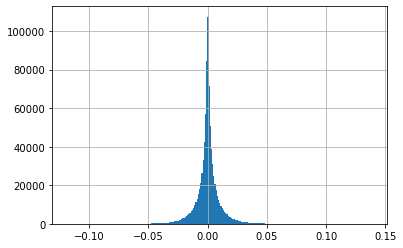

In [12]:
sg = pd.Series(auggrad[0].reshape(-1))
sg.hist(bins=255)

In [9]:
auggrad = agrad(data[0][idx][None, ...].to(cfg.device), data[1][idx], verbose=False, normalize=False)

[true]: 21
[pred]: 22.136


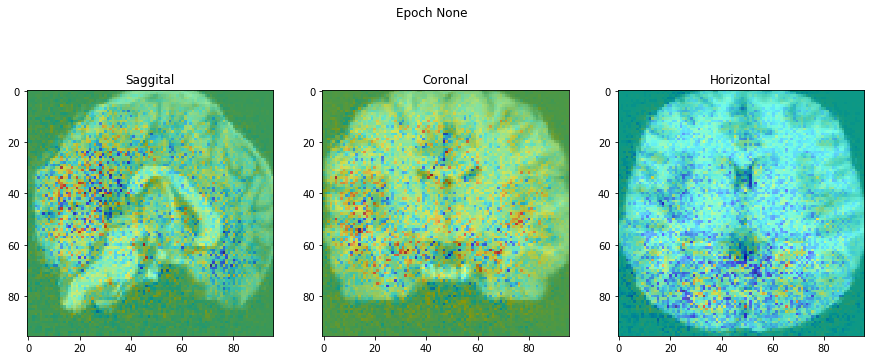

In [10]:
import matplotlib.pyplot as plt
plot_vismap(data[0][idx][0], smooth_grad[0], masked=True, threshold=50, save=True)

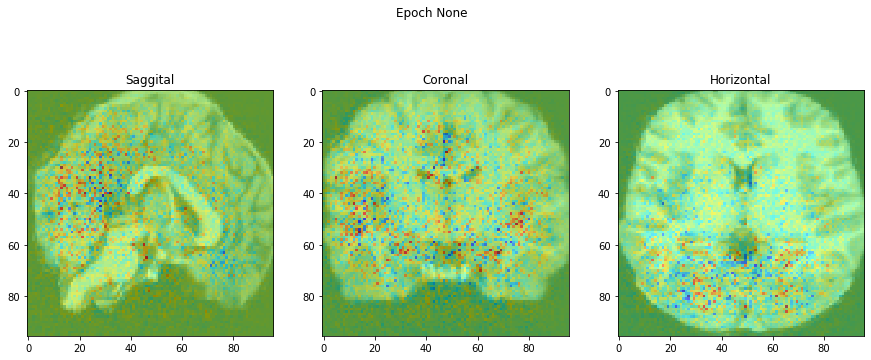

In [11]:
import matplotlib.pyplot as plt
plot_vismap(data[0][idx][0], auggrad[0], masked=False, threshold=50, save=True)

In [15]:
def brain_parser(path, full_path=True):
    
    root = '/'.join(path.split('/')[:2])+'/brainmask_nii/'
    fname = path.split('/')[-1].split('_tlrc')[0]+'.nii'
    return root + fname if full_path else root, fname.split('.nii')[0]

In [16]:
def convert2nifti(path, data, vismap):
    '''
    path: path of original dataloaders', e.g. '../../brainmask_tlrc/PAL318_mpr_wave1_orig-brainmask_tlrc.npy'
    data: a single brain of 5-dim torch.tensor. Will be converted to numpy automatically
    vismap: attention map derived from any methods of - GradCAM, GBP, GuidedGCAM
    
    Does not return anything but instead saved 2 nifti files (registrated brain, visualization map) in
    ../../attmap_result_pairs/filename/*.nii.gz 
    '''
    
    ROOT = '../../attmap_result_pairs/'
    fname = brain_parser(path, full_path=False)[1]
    
    if not os.path.exists(f'{ROOT}{fname}'):
        os.mkdir(f'{ROOT}{fname}')
    
    try:
        # Make Affine
        affine = nib.load(brain_parser(path)[0]).affine
        print('Affine loaded')

        # Save vismap as nifti
        vismap_nifti = nib.Nifti1Image(vismap, affine)
        nib.save(vismap_nifti, f'{ROOT}{fname}/{fname}_attmap.nii.gz')
        print('Saved vismap')

        # Save .npy brain as nifti
        brain = nib.Nifti1Image(data[0][0].numpy(), affine)
        nib.save(brain, f'{ROOT}{fname}/{fname}_brain.nii.gz')
        print('Saved tlrc brain')
    
    except:
        print('Error occurred')

In [17]:
ROOT = '../../attmap_result_pairs/'
path = train_dataset.data_files[15]
fname = brain_parser(path, full_path=False)[1]
f'{ROOT}{fname}/{fname}_attmap.nii.gz'

'../../attmap_result_pairs/PAL1615_mpr_wave1_orig-brainmask/PAL1615_mpr_wave1_orig-brainmask_attmap.nii.gz'

In [18]:
affine = nib.load(brain_parser(train_dataset.data_files[15], full_path=True)[0]).affine

In [19]:
fname = brain_parser(train_dataset.data_files[15], full_path=False)[1]

In [14]:
vismap_nifti = nib.Nifti1Image(smooth_grad, affine)

In [65]:
data[0][idx][None, ...][0][0][0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [87]:
smooth_grad.shape

(1, 96, 96, 96)

In [20]:
convert2nifti(train_dataset.data_files[10], data[0][idx][None, ...], smooth_grad[0])

Affine loaded
Saved vismap
Saved tlrc brain


In [ ]:
x = data[0].to(cfg.device)
x.requires_grad = True
output = model(x).squeeze()

In [19]:
output - data[1].to(cfg.device)

tensor([-27.3299], device='cuda:0', grad_fn=<SubBackward0>)

In [9]:
float(output.data.cpu())

55.670127868652344

In [85]:
pd.Series(smooth_grad.reshape(-1)).quantile(.5)

5.479762148752343e-05

In [ ]:
output.backward()
total_gradients = x.grad.data.cpu().numpy()

In [5]:
import numpy as np
class SmoothGrad:
    
    def __init__(self, pretrained_model, cfg, stdev=.1, n_samples=25):
        
        self.pretrained_model = pretrained_model
        self.stdev = stdev
        self.n_samples = n_samples
        self.cfg = cfg
        
    def __call__(self, x, y):
        
        x = x.data.cpu().numpy()
        stdev = self.stdev * (np.max(x) - np.min(x))
        total_gradients = np.zeros_like(x)
        print(f'Y: {y}')
        for i in range(self.n_samples):
            
            noise = np.random.normal(0, stdev, x.shape).astype(np.float32)
            x_plus_noise = torch.Tensor(x + noise)
            x_plus_noise = x_plus_noise.to(self.cfg.device)
            x_plus_noise.requires_grad = True
            output = self.pretrained_model(x_plus_noise).squeeze()
            print(output)
            output.backward()
            
            grad = x_plus_noise.grad.data.cpu().numpy()
            total_gradients += grad
            
        avg_gradients = total_gradients[0, ...] / self.n_samples
        
        return avg_gradients

In [3]:
cfg = load_config()
cfg.model_name = 'sfcn'
cfg.channel_number = [32, 64, 128, 256, 64]; cfg.refresh()
model, cfg.device = load_model(cfg.model_name, verbose=False, cfg=cfg)
model.load_state_dict(torch.load('./result/models/2021_03_30_2101_sfcn/best_sfcn_ep89-100_sd42_mae6.478.pth'))

train_dataset = DatasetPlus(cfg, augment=False)
sample_dl = DataLoader(train_dataset, batch_size=1)

data = next(iter(sample_dl))

Model Sfcn is selected.


In [23]:
data = train_dataset[2]

In [45]:
x = data[0][None, ...].data.cpu().numpy()
stdev = .05 * (np.max(x) - np.min(x))

noise = np.random.normal(0, stdev, x.shape).astype(np.float32)
x_plus_noise = torch.Tensor(x + noise)
x_plus_noise = x_plus_noise.to(cfg.device)

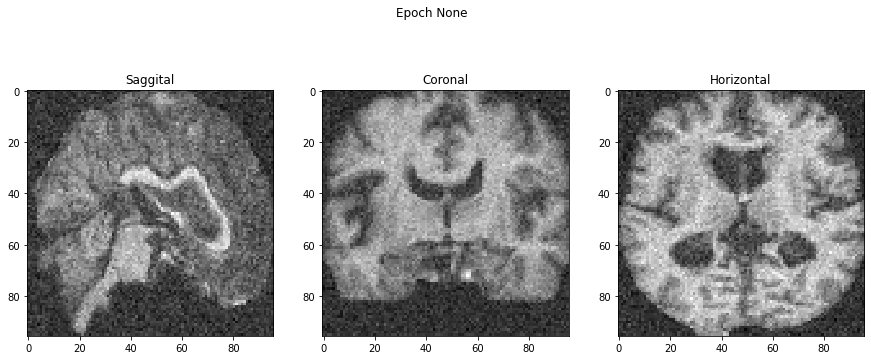

In [46]:
plot_vismap(x_plus_noise[0][0].cpu().numpy(), np.zeros_like(x)[0][0])

In [54]:
model(data[0][None, ...].to(cfg.device)), data[1]

(tensor([[[[[52.6280]]]]], device='cuda:0', grad_fn=<AddBackward0>),
 tensor(60.))

In [52]:
sgrad = SmoothGrad(model, cfg, stdev=.01)
smooth_grad = sgrad(data[0][None, ...], data[1])

tensor(60.0835, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(47.1417, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(52.2491, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(70.8981, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(47.7303, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(59.9730, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(47.5934, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(44.1349, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(48.0940, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(67.5712, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(56.3009, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(42.8347, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(41.4967, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(35.8505, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(42.3037, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(45.1591, device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor(47.4109, device='

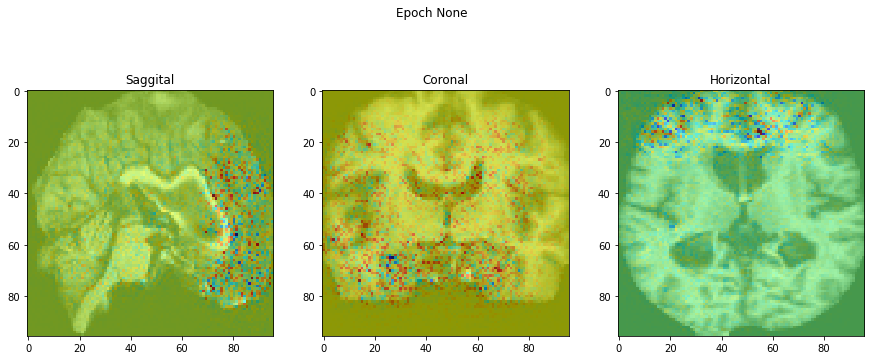

In [53]:
plot_vismap(data[0][0], smooth_grad[0], masked=False)

In [28]:
def plot_vismap(brain, vismap, masked=True, threshold=2,
                slc=48, alpha=.6, view=0, save=False, epoch=None):
    if masked:
        vismap = np.ma.masked_where(vismap < threshold, vismap)
    
    fig, axes = plt.subplots(ncols=3, figsize=(15, 6))

    fig.suptitle(f'Epoch {epoch}')

    axes[0].set_title('Saggital')
    axes[0].imshow(np.rot90(brain[slc, :, :]), cmap='gray', interpolation='none')
    axes[0].imshow(np.rot90(vismap[slc, :, :]), cmap='jet', interpolation='none', alpha=alpha)
    
    axes[1].set_title('Coronal')
    axes[1].imshow(np.rot90(brain[:, slc, :]), cmap='gray', interpolation='none')
    axes[1].imshow(np.rot90(vismap[:, slc, :]), cmap='jet', interpolation='none', alpha=alpha)

    axes[2].set_title('Horizontal')
    axes[2].imshow(np.rot90(brain[:, :, slc]), cmap='gray', interpolation='none')
    axes[2].imshow(np.rot90(vismap[:, :, slc]), cmap='jet', interpolation='none', alpha=alpha)
    
    if save:
        if not os.path.exists('./result/att_tmp_plots/'):
            os.mkdir('./result/att_tmp_plots/')
        plt.savefig(f'./result/att_tmp_plots/ep{str(epoch).zfill(3)}.png')
    plt.show()

# Dataloader for raw mri

In [1]:
from src.config import load_config
cfg = load_config()
cfg.registration = 'raw_cropped'

from src.data.data_util import *
ds = DatasetPlus(cfg, augment=True)
dl = DataLoader(ds, batch_size=16)

G:\내 드라이브\brain_data\workspace\3d_brain\src\config.py:17: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return CFG(yaml.load(yml_config_file))


Wall time: 13.5 s


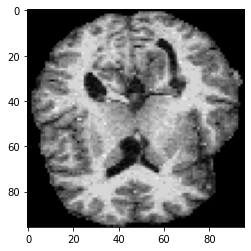

In [5]:
%%time
batch = next(iter(dl))

import matplotlib.pyplot as plt
plt.imshow(batch[0][0][0][:, 48, :].T, cmap='gray')

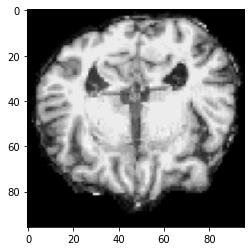

In [4]:
import matplotlib.pyplot as plt
plt.imshow(batch[0][5][0][:, 48, :].T, cmap='gray')

In [17]:
from src.config import load_config
cfg = load_config()
cfg.registration = 'raw'

from src.data.data_util import *
ds = DatasetPlus(cfg)
dl = DataLoader(ds, batch_size=16)

G:\내 드라이브\brain_data\workspace\3d_brain\src\config.py:17: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return CFG(yaml.load(yml_config_file))


In [19]:
ds.data_files[0]

'../../brainmask_nii/PAL318_mpr_wave1_orig-brainmask.nii'

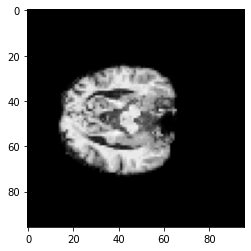

In [18]:
%timeit
batch = next(iter(dl))

import matplotlib.pyplot as plt
plt.imshow(batch[0][0][0][:, 48, :], cmap='gray')

In [31]:
# dset = MyDataset(CFG, augment=augment, fold=fold)
CFG = cfg

device = CFG.device

In [32]:
model.train()
predictions, targets = [], []

x, y = batch
x, y = x.to(device), y.to(device)

optimizer.zero_grad()

y_pred = model.forward(x).to(device).squeeze(1)
predictions.append(y_pred.cpu())
targets.append(y.cpu())

In [33]:
loss = loss_fns['mse'](y_pred, y)

In [34]:
# Track down results
DP = trn_dp
DP.loss.batch_update(loss.item(), 1)
DP.mae.batch_update(loss_fns['mae'](y_pred, y).item(), 1)
DP.rmse.batch_update(loss_fns['rmse'](y_pred, y).item(), 1)

if CFG.lamb:
    l2_reg = torch.tensor(0.).to(device)
    for param in model.parameters():
        l2_reg += torch.norm(param)
    loss += CFG.lamb * l2_reg

loss.backward()
optimizer.step()

del x, y, y_pred

torch.cuda.empty_cache()
DP.loss.clear()
DP.mae.clear()
DP.rmse.clear()
DP.refresh()

predictions = torch.cat(predictions).detach().numpy()
targets = torch.cat(targets).detach().numpy()

# Quality check for saved ElasticDeformation

In [ ]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
path = '../../brainmask_elasticdeform/*.npy'
files = glob(path)
ori = '../../brainmask_tlrc/*.npy'
ori_files = glob(ori)
ori_files.sort()
files.sort()
files

flip
elastic_deform
affine
affine
elastic_deform
flip
flip
flip
affine
affine
affine
affine
flip
elastic_deform
affine
affine


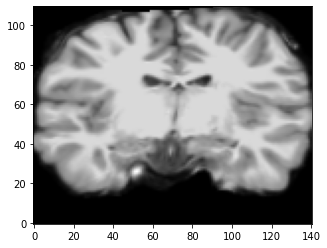

In [26]:
fig, ax = plt.subplots()
batch = next(iter(aug_dl))
ax.imshow(batch[0][2][0][:, 86, :].T, cmap="gray", origin="lower")

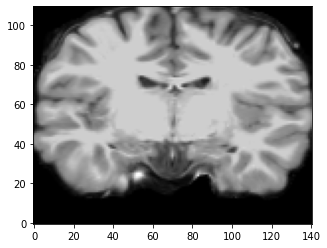

In [25]:
fig, ax = plt.subplots()
ax.imshow(batches[0][2][0][:, 86, :].T, cmap="gray", origin="lower")

In [14]:
ori_files[1], files[1]

('../../brainmask_tlrc\\IXI016-Guys-0697-T1-brainmask_tlrc.npy',
 '../../brainmask_elasticdeform\\IXI016-Guys-0697-T1-brainmask_tlrc.npy')

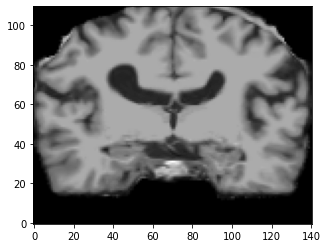

In [23]:
fig, ax = plt.subplots()
original = np.load(ori_files[1])
ax.imshow(original[:, 86, :].T, cmap="gray", origin="lower")

# Torchio Time Check

In [4]:
import torchio as tio
import matplotlib.pyplot as plt

In [2]:
from src.config import *
cfg = load_config()

G:\My Drive\brain_data\workspace\3d_brain\src\config.py:17: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return CFG(yaml.load(yml_config_file))


In [7]:
cfg.test = False
aug_dset = MyDataset(cfg, augment=True)
aug_dl = DataLoader(aug_dset, cfg.batch_size)
cfg.test = True
tst_dset = MyDataset(cfg)
tst_dl = DataLoader(tst_dset, cfg.batch_size)

In [9]:
tst_batch = next(iter(tst_dl))

In [5]:
from src.data_util import *

cfg['verbose_loader'] = True
cfg['augmentation'] = {
    'affine': 0,
    'flip': 0,
    'elastic_deform': 1,
}
aug_dset = MyDataset(cfg, augment=True)
aug_dl = DataLoader(aug_dset, cfg.batch_size)

In [23]:
aug_batch = next(iter(aug_dl))

elastic_deform
elastic_deform
elastic_deform
elastic_deform
elastic_deform
elastic_deform
elastic_deform
elastic_deform
elastic_deform
elastic_deform
elastic_deform
elastic_deform
elastic_deform
elastic_deform
elastic_deform
elastic_deform


In [28]:
idx = 5

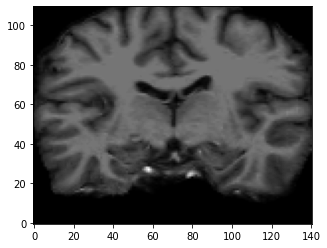

In [29]:
fig, ax = plt.subplots()
ax.imshow(tst_batch[0][idx][0][:, 86, :].T, cmap="gray", origin="lower")

NameError: name 'aug_batch' is not defined

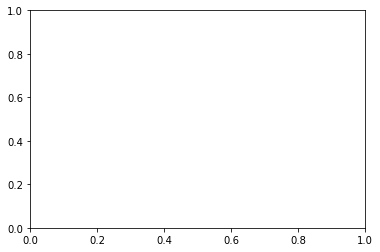

In [15]:
fig, ax = plt.subplots()
ax.imshow(aug_batch[0][idx][0][:, 86, :].T, cmap="gray", origin="lower")

In [26]:
from src.data_util import *

dset = MyDataset(cfg, augment=None)
dl = DataLoader(dset, cfg.batch_size)

ori_batch = next(iter(dl))

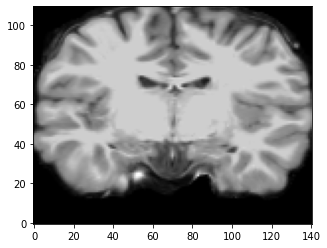

In [31]:
fig, ax = plt.subplots()
ax.imshow(ori_batch[0][idx][0][:, 86, :].T, cmap="gray", origin="lower")

In [51]:
substtt = ori_batch[0][idx][0] - aug_batch[0][idx][0]

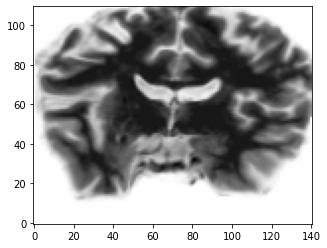

In [52]:
fig, ax = plt.subplots()
ax.imshow(substtt[:, 86, :].T, cmap="gray", origin="lower")

In [22]:
%%time
tio.RandomAffine()(sample_batch[0])

Wall time: 70 ms


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [25]:
%%time
tio.RandomFlip(axes=['left-right'])(sample_batch[0])

Wall time: 3.98 ms


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [26]:
%%time
tio.RandomElasticDeformation()(sample_batch[0])

Wall time: 1.25 s


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [20]:
%%time
transform(sample_batch[0])

Wall time: 1.2 s


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

## TorchIO

In [11]:
import torchio as tio
import matplotlib.pyplot as plt

In [17]:
train_dset = MyDataset(task_type='age')
test_dset = MyDataset(task_type='age', test=True)
aug_dset = MyDataset(task_type='age', augment=True)
train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

In [50]:
transform = tio.OneOf({
    tio.RandomAffine(),
    tio.RandomFlip(axes=['left-right'])
})

In [51]:
transform_sample = transform(sample)

Init signature:   
tio.RandomElasticDeformation(   
    num_control_points: Union[int, Tuple[int, int, int]] = 7,   
    max_displacement: Union[float, Tuple[float, float, float]] = 7.5,   
    locked_borders: int = 2,   
    image_interpolation: str = 'linear',   
    **kwargs,   
)   

In [23]:
random_elastic = tio.RandomElasticDeformation()
elastic_sample = random_elastic(sample)

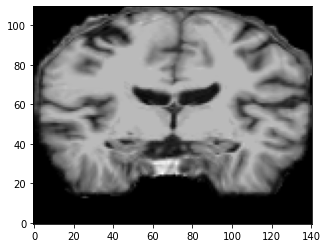

In [27]:
fig, ax = plt.subplots()
ax.imshow(sample[0][:, 86, :].T, cmap="gray", origin="lower")

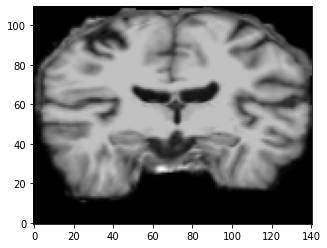

In [28]:
fig, ax = plt.subplots()
ax.imshow(elastic_sample[0][:, 86, :].T, cmap="gray", origin="lower")

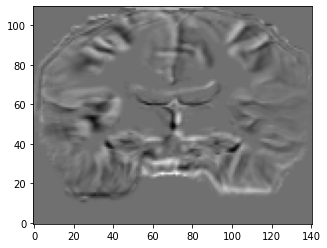

In [29]:
fig, ax = plt.subplots()
ax.imshow((sample - elastic_sample)[0][:, 86, :].T, cmap="gray", origin="lower")

In [75]:
import matplotlib.pyplot as plt

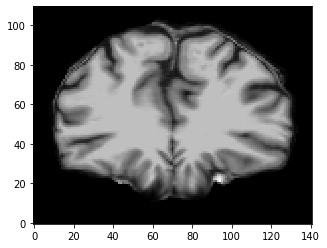

In [76]:
fig, ax = plt.subplots()
ax.imshow(sample_lr[:, 36, :].T, cmap="gray", origin="lower")

In [29]:
sample_shift1.shape

(141, 172, 110)

In [30]:
sample.shape

torch.Size([141, 172, 110])

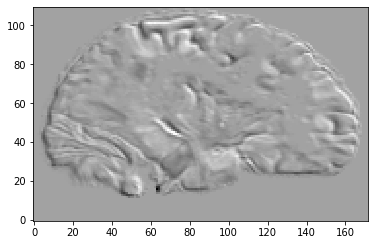

In [31]:
fig, ax = plt.subplots()
ax.imshow((torch.tensor(sample_shift1) - sample)[36, :, :].T, cmap="gray", origin="lower")

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


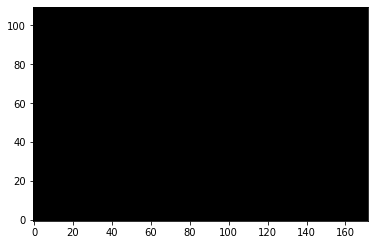

In [32]:
fig, ax = plt.subplots()
ax.imshow((torch.tensor(sample) - sample)[36, :, :].T, cmap="gray", origin="lower")

In [23]:
import matplotlib.pyplot as plt

In [15]:
RandomAffine(degrees=1, translate=[1, 1, 1])

AssertionError: translate should be a list or tuple and it must be of length 2.

In [1]:
import numpy as np
from src.architectures.dinsdale import *
from torchsummary import summary
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = Dinsdale(1, 1)

# model.to(device)
summary(model, input_size=(1, 96, 96, 96))

In [3]:
x = Tensor(np.zeros((2, 1, 96, 96, 96))).to(device)

In [4]:
outputs = model.forward(x)

In [6]:
outputs.shape

torch.Size([2, 1])

In [1]:
from src.architectures.inception_copy import *
import numpy as np
from src.architectures.inception import *
from torchsummary import summary
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
model = inception_v3()

G:\내 드라이브\brain_data\workspace\3d_brain\src\architectures\inception_copy.py:81: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


In [ ]:
model

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
summary(model, input_size=(1, 96, 96, 96))

RuntimeError: expected stride to be a single integer value or a list of 2 values to match the convolution dimensions, but got stride=[1, 1, 1]

In [4]:
x = Tensor(np.zeros((2, 1, 96, 96, 96))).to(device)

In [5]:
outputs = model.forward(x)

In [6]:
outputs.shape

torch.Size([2, 128, 96, 96, 96])

In [1]:
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from src.run import run
from src.dataloader import MyDataset
from src.evaluate import eval, loss_plot, result_plot
from src.model.vanilla import Vanilla3d

model_list = {
    'vanilla': Vanilla3d
}

optimizer_list = {
    'adam': optim.Adam
}

loss_list = {
    'mse': nn.MSELoss,
    'bce': nn.BCELoss
}

scheduler_list = {
    'cosine': optim.lr_scheduler.CosineAnnealingLR
}

In [2]:
class Args:
    
    def __init__(self, task_type='binary', batch_size=8):
        
        self.task_type = task_type
        self.batch_size = batch_size

In [3]:
args = Args()

In [4]:
# 00. Load Data
train_dset = MyDataset(args.task_type)
test_dset = MyDataset(args.task_type, test=True)

train_loader = DataLoader(train_dset, batch_size=args.batch_size)
test_loader = DataLoader(test_dset, batch_size=args.batch_size)

In [9]:
import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [139]:
epi_img_data = x[0]

In [140]:
epi_img_data = epi_img_data.squeeze()

In [141]:
epi_img_data.shape

torch.Size([64, 64, 64])

In [27]:
from glob import glob
import nibabel as nib
idx = 1000
data_files = glob('../../brainmask_nii/*.nii')
x = nib.load(data_files[idx]).get_fdata()

(array([1.510157e+07, 1.099420e+05, 1.296440e+05, 1.715710e+05,
        2.238530e+05, 2.671790e+05, 1.878920e+05, 1.399780e+05,
        1.476650e+05, 1.468330e+05, 1.428590e+05, 5.612000e+03,
        7.970000e+02, 4.070000e+02, 3.170000e+02, 2.610000e+02,
        2.390000e+02, 1.930000e+02, 2.180000e+02, 1.860000e+02]),
 array([  0. ,  10.8,  21.6,  32.4,  43.2,  54. ,  64.8,  75.6,  86.4,
         97.2, 108. , 118.8, 129.6, 140.4, 151.2, 162. , 172.8, 183.6,
        194.4, 205.2, 216. ]),
 <a list of 20 Patch objects>)

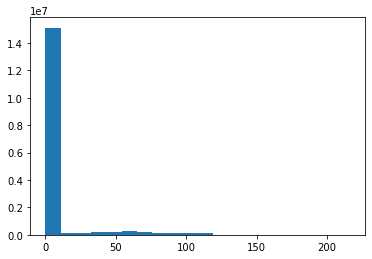

In [28]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(x.reshape(-1), 20)

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x.reshape(-1, 1))
x_scaled = scaler.transform(x.reshape(-1, 1))

(array([1.510157e+07, 1.099420e+05, 1.296440e+05, 1.715710e+05,
        2.238530e+05, 2.671790e+05, 1.878920e+05, 1.399780e+05,
        1.476650e+05, 1.468330e+05, 1.428590e+05, 5.612000e+03,
        7.970000e+02, 4.070000e+02, 3.170000e+02, 2.610000e+02,
        2.390000e+02, 1.930000e+02, 2.180000e+02, 1.860000e+02]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

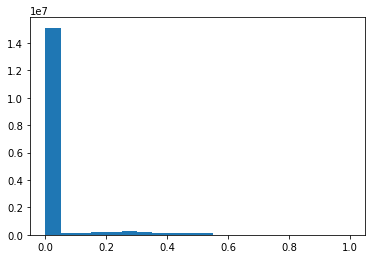

In [32]:
plt.hist(x_scaled.reshape(-1), 20)

In [ ]:
# 01. Define Model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')
model = model_list[args.model](args.task_type).to(device)

In [ ]:
# 02. Setups
optimizer = optimizer_list[args.optimizer](model.parameters(),
                                           lr=args.learning_rate)
scheduler = scheduler_list[args.scheduler](optimizer, len(train_loader), eta_min=0) if args.scheduler else None
loss_fn = loss_list[args.loss_function]()
EPOCHS = range(args.epochs)

In [ ]:
# 03. Run
summary = SummaryWriter(f'./tensorboard/{datetime.now().strftime("%Y-%m-%d_%H%M")}') if args.save else None
fname = f'{datetime.now().strftime("%Y-%m-%d_%H%M-")}' if args.save else None
model, losses = run(model=model, epochs=EPOCHS, train_loader=train_loader, test_loader=test_loader,
                    optimizer=optimizer, loss_fn=loss_fn, device=device,
                    summary=summary, scheduler=scheduler, verbose=True)

if args.save:
    torch.save(model, f"./models/{fname}_model.pth")

In [ ]:
# 04. Evaluate
# 04-1. Loss Plot
#loss_plot(*losses, EPOCHS, args.loss_function)

# 04-2. Result Plot
train_true, train_pred = eval(model=model, loader=train_loader, device=device)
result_plot(task_type=args.task_type, trues=train_true, preds=train_pred, title='Train', fname=fname)

test_true, test_pred = eval(model=model, loader=test_loader, device=device)
result_plot(task_type=args.task_type, trues=test_true, preds=test_pred, title='Test', fname=fname)

### Debugging Holygrail

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn.image import resample_img
from nilearn.image import new_img_like, load_img, clean_img, crop_img
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
import glob

# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
from torchsummary import summary

from IPython import display
%matplotlib inline

In [2]:
def show_slice(data, idx=0):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    im=axs[0].imshow(data[idx,:,:])
    fig.colorbar(im, ax=axs[0])
    
    im=axs[1].imshow(data[:,idx,:])
    fig.colorbar(im, ax=axs[1])
    
    im=axs[2].imshow(data[:,:,idx])
    fig.colorbar(im, ax=axs[2])
    
    plt.suptitle('Slice {}, dim={}x{}x{}'.format(idx, *data.shape))
    plt.show()

In [3]:
def process_scans(rsc='../../brainmask_nii/',resample=3, crop=True,
                 subsample=None):
    
    df = pd.read_csv('../rsc//age_ixi_and_oasis.csv')
    files = df['id']
    
    X = []
    y = df['binary'].values
    yage = df['age'].values
    for fname in tqdm(files):
        
        try: 
            tmp = nib.load(rsc+fname+'-brainmask.nii')
        except:
            tmp = nib.load(rsc+fname+'.nii-brainmask.nii')
            
        dtmp = resample_img(tmp, target_affine=np.eye(3)*resample*1.0,
                            interpolation='nearest')
        if crop:
            
            # we know that in our sample 53 70 58 are the largest
            # brains, so we crop first and then embed
            
            tc = crop_img(dtmp).get_fdata()
            te = np.zeros((53,70,58))
            
            d1 = np.floor((53 - tc.shape[0]) / 2).astype(np.int16)
            d2 = np.floor((70 - tc.shape[1]) / 2).astype(np.int16)
            d3 = np.floor((58 - tc.shape[2]) / 2).astype(np.int16)
            
            te[d1:d1+tc.shape[0],
               d2:d2+tc.shape[1],
               d3:d3+tc.shape[2]] = tc
            X.append(te)
            
        else:
            
            X.append(dtmp.get_fdata()[:86,:86,:86])
            
    return X, y, yage

X, y, yage = process_scans()
# X = np.array(X)
# np.save('X_crop.npy', X)
# np.save('y.npy', y)
# np.save('yage.npy', yage)

  1%|█                                                                               | 15/1179 [00:03<04:54,  3.95it/s]


KeyboardInterrupt: 

In [4]:
X = np.load('X_crop.npy', allow_pickle=True)
y = np.load('yage.npy')

In [5]:
for i in range(len(X)):
    tmp = X[i].reshape(-1)
    mitmp = np.min(tmp)
    matmp = np.max(tmp)
    X[i]= (X[i]-mitmp)/(matmp-mitmp)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

del X, y

In [7]:
# since X.shape is (1187*.8, 53, 70, 58) and we need to add channel axis, which is 1
X_train = torch.from_numpy(X_train).float().view(X_train.shape[0], 1, 53, 70, 58)
X_test  = torch.from_numpy(X_test).float().view(X_test.shape[0], 1, 53, 70, 58)

y_train = torch.from_numpy(y_train).float()
y_test  = torch.from_numpy(y_test).float()

In [8]:
batch_size = 16

trn_ds = torch.utils.data.TensorDataset(X_train, y_train)
tst_ds = torch.utils.data.TensorDataset(X_test, y_test)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=batch_size, shuffle=False)

del X_train, X_test

In [9]:
num_classes = 1

# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(1, 8)
        self.conv_layer2 = self._conv_layer_set(8, 16)
        self.conv_layer3 = self._conv_layer_set(16, 32)
        self.conv_layer4 = self._conv_layer_set(32, 64)
        
        self.fc1 = nn.Linear(2304, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
        
        self.batch=nn.BatchNorm1d(128)
        self.drop=nn.Dropout(p=0.15)        
        
        
    def _conv_layer_set(self, in_c, out_c):
        
        conv_layer = nn.Sequential(
            nn.Conv3d(in_c, out_c, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(out_c),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
        )
        
        return conv_layer
    
    
    def _conv_layer_set2(self, in_c, out_c):
        
        conv_layer = nn.Sequential(
            nn.Conv3d(in_c,  out_c, kernel_size=(2,2,2), padding=1),
            nn.Conv3d(out_c, out_c, kernel_size=(2,2,2), padding=1),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),
        )
        
        return conv_layer

    
    def forward(self, x):
        
        # Set 1
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.drop(out)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.drop(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        
        return out

In [10]:
#Definition of hyperparameters
n_iters = 1000
num_epochs = n_iters / (len(trn_dl) / batch_size)
num_epochs = int(num_epochs)
device = torch.device("cuda:0") # use cuda device 0

print('running',num_epochs,'on',device)

# Create CNN
model = CNNModel()
model.to(device)
print(summary(model, input_size=(1,53,70,58)))

# # Cross Entropy Loss 
# error = nn.CrossEntropyLoss()

# MSR Loss
error = nn.MSELoss()

# SGD Optimizer
learning_rate = 0.00005
optimizer = torch.optim.SGD(model.parameters(),
                             lr=learning_rate,
                             weight_decay=0.0005,
                             momentum=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2, last_epoch=-1) 

running 271 on cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [-1, 8, 53, 70, 58]             224
       BatchNorm3d-2        [-1, 8, 53, 70, 58]              16
              ReLU-3        [-1, 8, 53, 70, 58]               0
         MaxPool3d-4        [-1, 8, 26, 35, 29]               0
            Conv3d-5       [-1, 16, 26, 35, 29]           3,472
       BatchNorm3d-6       [-1, 16, 26, 35, 29]              32
              ReLU-7       [-1, 16, 26, 35, 29]               0
         MaxPool3d-8       [-1, 16, 13, 17, 14]               0
            Conv3d-9       [-1, 32, 13, 17, 14]          13,856
      BatchNorm3d-10       [-1, 32, 13, 17, 14]              64
             ReLU-11       [-1, 32, 13, 17, 14]               0
        MaxPool3d-12          [-1, 32, 6, 8, 7]               0
           Conv3d-13          [-1, 64, 6, 8, 7]          55,360
      BatchNorm3d

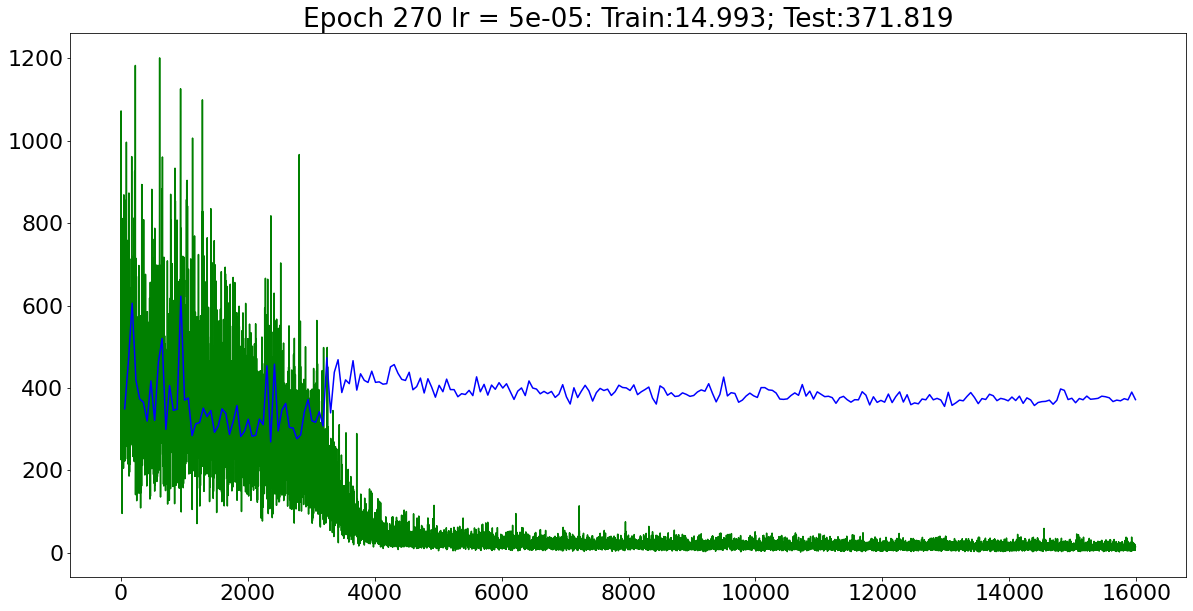

In [12]:
torch.cuda.empty_cache()

plt.figure(figsize=(20,10))
axes = plt.gca() # get current axis?
axes.set_ylim([0,1000])
plt.grid(True)
plt.rcParams.update({'font.size': 22})

# CNN model training
count = 0
loss_list = []
count_list=[]
batch_accuracy_list = []
accuracy_list = []
for epoch in range(num_epochs):
    
    batch_accuracy = 0
    batch_total = 0
    #scheduler.step()
    for i, (train, labels) in enumerate(trn_dl):  
        
        #train = Variable(images.view(batch_size,1,86,86,86))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train.to(device)).squeeze()
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels.to(device))
        loss_list.append(loss.data)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        plt.cla()
        plt.plot(loss_list,'g-')
        display.display(plt.gcf()) # get current figure
        display.clear_output(wait=True) 

        # Total number of labels
        batch_total += 1
        batch_accuracy += loss.data
        
    batch_accuracy_list.append(batch_accuracy/batch_total)
        
#         # Get predictions from the maximum value
#         predicted = torch.max(outputs.data, 1)[1]

#         # Total number of labels
#         batch_total += len(labels)
#         batch_accuracy += (predicted == labels.to(device)).sum().data
    
#     batch_accuracy_list.append(100*batch_accuracy/batch_total)

    with torch.no_grad():

        # below code is for classification I guess
#     correct = 0
#     total = 0
#     # Iterate through test dataset
#     for test, labels in test_loader:

#         #test = Variable(images)
#         # Forward propagation
#         outputs = model(test.to(device))

#         # Get predictions from the maximum value
#         predicted = torch.max(outputs.data, 1)[1]

#         # Total number of labels
#         total += len(labels)
#         correct += (predicted == labels.to(device)).sum().data

#     accuracy = 100 * correct / float(total)
#     plt.title('Epoch {:}: Train:{:.3f}; Test:{:.3f}'.format(
#               epoch,100*batch_accuracy/batch_total,accuracy))
#     accuracy_list.append(accuracy)

        accuracy = 0
        total = 0
        for test, labels in tst_dl:
            
            # Forward propagation
            outputs = model(test.to(device)).squeeze()
            accuracy += error(outputs,labels.to(device))
            total +=1
            
        count_list.append(count)
        accuracy_list.append(accuracy)
        
    plt.plot(np.array(count_list), np.array(accuracy_list)/total, 'b')
    plt.title('Epoch {:} lr = {:}: Train:{:.3f}; Test:{:.3f}'.format(
                epoch,
                learning_rate,#scheduler.get_lr()[0],
                batch_accuracy/batch_total,
                accuracy/total))
    
    display.display(plt.gcf())
    display.clear_output(wait=True) 

### Picture Debug

Deal with differences between IXI & Oasis1 & Oasis3

In [6]:
import pandas as pd

y = pd.read_csv('../rsc/age_ixi_and_oasis.csv')

In [7]:
from src.dataloader import *

In [10]:
data_files = glob('../../brainmask_nii/*.nii')
data_files.sort()

In [24]:
i = 1

ixi_idx = 0
oas1_idx = 314
oas3_idx = 800

In [25]:
ixi = data_files[ixi_idx+i]
oas1 = data_files[oas1_idx+i]
oas3 = data_files[oas3_idx+i]

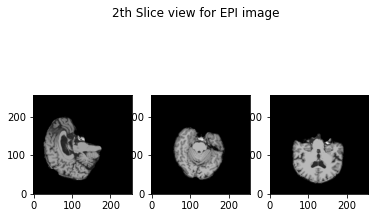

In [26]:
ixi = SliceViewer(nib.load(ixi).get_fdata())
ixi.triple_view()

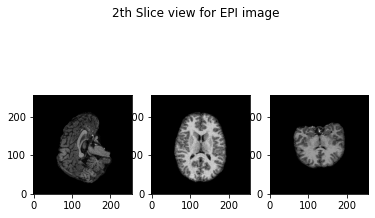

In [27]:
oas1 = SliceViewer(nib.load(oas1).get_fdata())
oas1.triple_view()

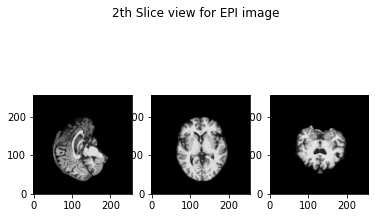

In [28]:
oas3 = SliceViewer(nib.load(oas3).get_fdata())
oas3.triple_view()

# With registered IXIs(312)

## Preprocess: resize down to the maximum voxel

Finding biggest brain - but it'll be same since they're registered...but just to check

In [4]:
import numpy as np
from glob import glob
from itertools import groupby

from tqdm.notebook import tqdm

In [5]:
data_files_reg = glob('../../brainmask_reg/*.npy')

In [8]:
idxs = [[256, 0] for _ in range(3)]
for sample in tqdm(data_files_reg):
    
    maxs = [[] for _ in range(3)]
    sample = np.load(sample)
    for i in range(256):
        
        maxs[0].append(sample[i, :, :].max())
        maxs[1].append(sample[:, i, :].max())
        maxs[2].append(sample[:, :, i].max())
        
    
    for i in range(3):
        reference = list(filter(lambda x: x > 1, [len(list(g)) for k, g in groupby(maxs[i])]))
        idxs[i][0] = min(idxs[i][0], reference[0])
        idxs[i][1] = max(idxs[i][1], reference[-1])

In [9]:
idxs

[[55, 55], [44, 70], [20, 63]]

In [10]:
idxs_correction = [[_[0], 256 - _[1]]for _ in idxs]
idxs_correction

[[55, 201], [44, 186], [20, 193]]

53 70 58

In [11]:
idxs_subtraction = [_[1] - _[0] for _ in idxs_correction]

In [12]:
idxs_subtraction

[146, 142, 173]